In [27]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# directories and paths
test_path = Path("/kaggle/input/labeled-chest-xray-images/chest_xray/test/")
train_path = Path("/kaggle/input/labeled-chest-xray-images/chest_xray/train/")

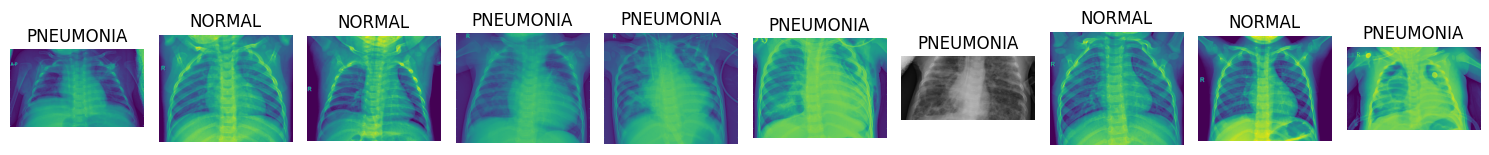

In [3]:
# Display some of the images
image_files_with_labels = [(str(image_path), image_path.parent.name) for image_path in train_path.glob("**/*.jpeg")]
num_images_to_display = 10
selected_images = random.sample(image_files_with_labels, num_images_to_display)
plt.figure(figsize=(15, 15))
for i, (image_path, label) in enumerate(selected_images):
    plt.subplot(3, num_images_to_display, i + 1)
    plt.imshow(plt.imread(image_path))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
# Divide data in two parts 1 data directory 2 label (parent.name)
train_set = [(str(image_path), image_path.parent.name) for image_path in train_path.glob("**/*.jpeg")]
test_set = [(str(image_path), image_path.parent.name) for image_path in test_path.glob("**/*.jpeg")]

train, label_train = zip(*train_set)
test, label_test = zip(*test_set)

# Function that format and convert img
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Load and resize image
    img_array = img_to_array(img)  # Convert image to array
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

x_train_samp = np.array([preprocess_image(x) for x in train])
x_test_samp = np.array([preprocess_image(x) for x in test])

x_train_samp.shape, x_test_samp.shape # check shapes

((5232, 224, 224, 3), (624, 224, 224, 3))

In [5]:
# Encode and prepare data
encoder = OrdinalEncoder() # Use ordinal encoder since we have binary classification
label_train = np.array(label_train).reshape(-1, 1) # label_train is tuple make it numpy for training
y_train_samp = encoder.fit_transform(label_train) 
y_train_samp.shape

(5232, 1)

In [6]:
# The same applies with test set
label_test = np.array(label_test).reshape(-1, 1)
y_test_samp = encoder.fit_transform(label_test)
y_test_samp.shape

(624, 1)

In [36]:
# Set seeds for reproducibility
tf.random.set_seed(45)
np.random.seed(45)

# Define augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Define your model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [49]:
# Train the model
history = model.fit(
    datagen.flow(x_train_samp, y_train_samp, batch_size=32),
    steps_per_epoch=int(len(x_train_samp) / 32),
    epochs=5,
    validation_data=(x_test_samp, y_test_samp),
    callbacks=[early_stopping]
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 282ms/step - accuracy: 0.9147 - loss: 0.2066 - val_accuracy: 0.8013 - val_loss: 0.4620
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.1103 - val_accuracy: 0.8173 - val_loss: 0.4405
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 273ms/step - accuracy: 0.9065 - loss: 0.2242 - val_accuracy: 0.9038 - val_loss: 0.2777
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2715 - val_accuracy: 0.9022 - val_loss: 0.2720
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 273ms/step - accuracy: 0.9112 - loss: 0.2258 - val_accuracy: 0.8990 - val_loss: 0.2841


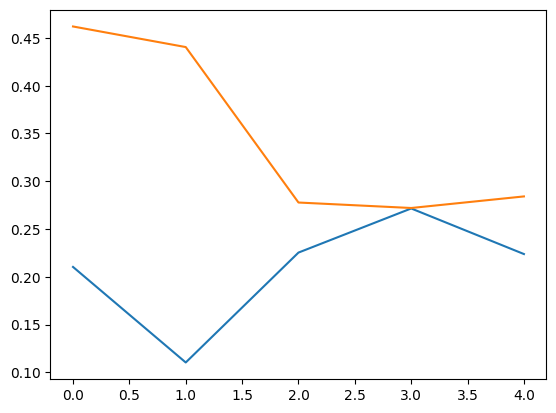

In [50]:
# Accuracy per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

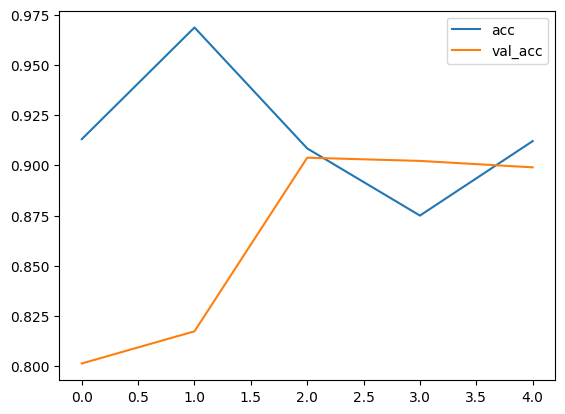

In [51]:
# Accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [22]:
yhat = model.predict(x_test_samp) # Predict
y_pred = (yhat > 0.5).astype(int) # threhold

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


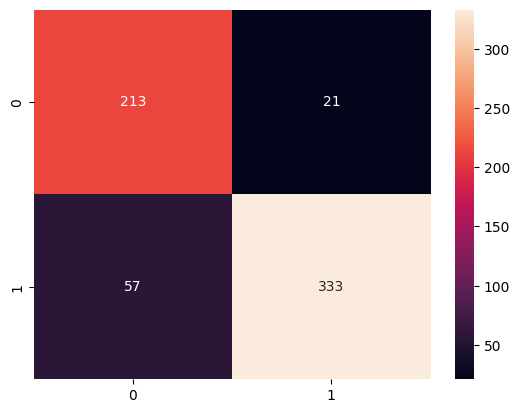

In [23]:
# Draw Confusion Matrix
sns.heatmap(confusion_matrix(y_test_samp, y_pred), annot=True, fmt='g')
plt.show()

In [24]:
# Classification report
print(classification_report(y_test_samp, y_pred)) # Classification report
print("Model accuracy: ", accuracy_score(y_test_samp, y_pred)) # Model accuracy

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       234
         1.0       0.94      0.85      0.90       390

    accuracy                           0.88       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624

Model accuracy:  0.875


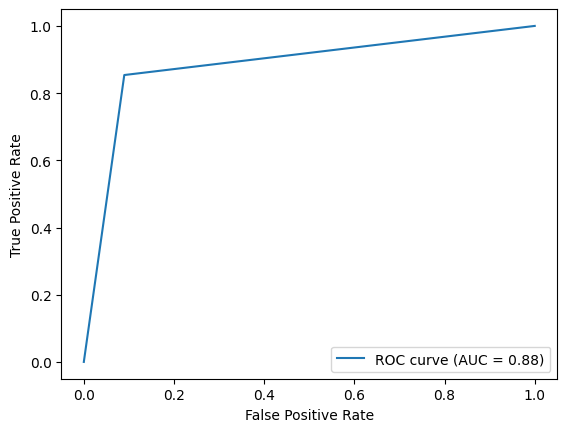

In [25]:
# ROC, AUC Curves
fpr, tpr, thresholds = metrics.roc_curve(y_test_samp, y_pred)
roc_auc = metrics.auc(fpr,tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

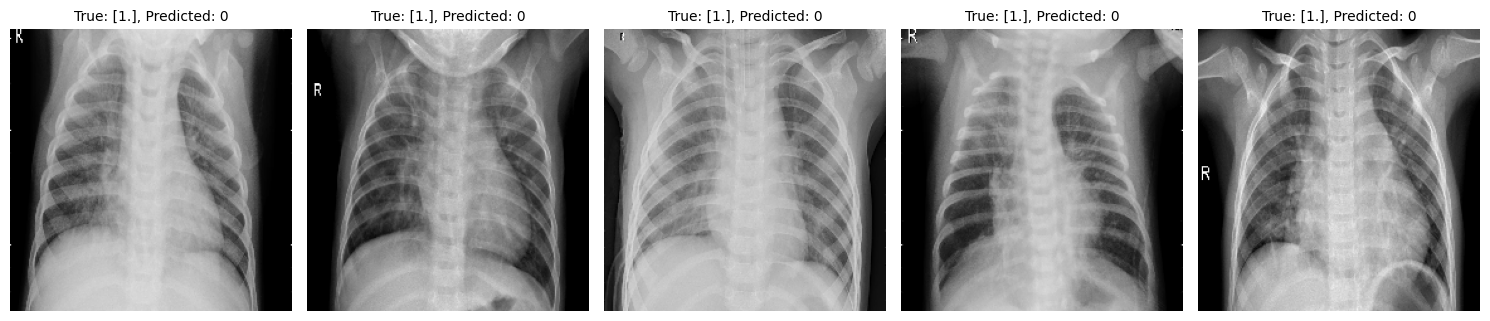

In [47]:
# Find misclassified indices
misclassified_indices = np.where(y_test_samp.flatten() != np.round(y_pred.flatten()))[0]

# Get misclassified images and labels
misclassified_X = x_test_samp[misclassified_indices]
misclassified_y_true = y_test_samp[misclassified_indices]
misclassified_y_pred = np.round(y_pred.flatten()[misclassified_indices])

# Display misclassified images
plt.figure(figsize=(15, 5))
num_images = 5
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(misclassified_X[i])
    plt.title(f'True: {misclassified_y_true[i]}, Predicted: {misclassified_y_pred[i]}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
tf.keras.models.save_model(model, 'model.h5')